# 分析Prosper数据——EDA

## 目录
* [项目综述](#项目综述)
* [分析过程](#分析过程)
 * [了解数据内容](#了解数据内容)
 * [单变量分析](#单变量分析)

### 项目综述
项目数据源是Prosper的数据。Prosper是美国一家不同于传统借贷的P2P借贷服务的公司，服务内容是贷款人贷款和借款人获取投资收益，而公司收益是从贷方和借方收取服务费。本次项目是站在投资人的角度，投资的收益是从借款人如约还款来实现，利用EDA的思路分析投资价值——因此需要分析借款人的借款信息和还款信息，期望能够证实P2P借贷方式存在投资价值。

In [1]:
library(ggplot2)
library(RColorBrewer)
library(psych)
library(dplyr)
library(tidyr)
library(reshape2)
library(gridExtra)


Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# load data
rawprosper <- read.csv("prosperLoanData.csv", sep=",", stringsAsFactor=FALSE)

In [3]:
dim(rawprosper)

[1] 113937     81

In [4]:
# know the structure of the data
str(rawprosper)

'data.frame':	113937 obs. of  81 variables:
 $ ListingKey                         : chr  "1021339766868145413AB3B" "10273602499503308B223C1" "0EE9337825851032864889A" "0EF5356002482715299901A" ...
 $ ListingNumber                      : int  193129 1209647 81716 658116 909464 1074836 750899 768193 1023355 1023355 ...
 $ ListingCreationDate                : chr  "2007-08-26 19:09:29.263000000" "2014-02-27 08:28:07.900000000" "2007-01-05 15:00:47.090000000" "2012-10-22 11:02:35.010000000" ...
 $ CreditGrade                        : chr  "C" "" "HR" "" ...
 $ Term                               : int  36 36 36 36 36 60 36 36 36 36 ...
 $ LoanStatus                         : chr  "Completed" "Current" "Completed" "Current" ...
 $ ClosedDate                         : chr  "2009-08-14 00:00:00" "" "2009-12-17 00:00:00" "" ...
 $ BorrowerAPR                        : num  0.165 0.12 0.283 0.125 0.246 ...
 $ BorrowerRate                       : num  0.158 0.092 0.275 0.0974 0.2085 ...
 $ LenderY

In [5]:
print(sort(names(rawprosper)))

 [1] "AmountDelinquent"                    "AvailableBankcardCredit"            
 [3] "BankcardUtilization"                 "BorrowerAPR"                        
 [5] "BorrowerRate"                        "BorrowerState"                      
 [7] "ClosedDate"                          "CreditGrade"                        
 [9] "CreditScoreRangeLower"               "CreditScoreRangeUpper"              
[11] "CurrentCreditLines"                  "CurrentDelinquencies"               
[13] "CurrentlyInGroup"                    "DateCreditPulled"                   
[15] "DebtToIncomeRatio"                   "DelinquenciesLast7Years"            
[17] "EmploymentStatus"                    "EmploymentStatusDuration"           
[19] "EstimatedEffectiveYield"             "EstimatedLoss"                      
[21] "EstimatedReturn"                     "FirstRecordedCreditLine"            
[23] "GroupKey"                            "IncomeRange"                        
[25] "IncomeVerifiable"     

### 了解数据内容
该数据集的观测值为113937个，具有81个变量。变量中包括了借款人的信息：借款人类似ID信息(MemberKey)，借款人借款开始日期(LoanOriginationDate)，借款人所在州(BorrowerState)，收入范围(IncomeRange)，债务收入比(DebtToIncomeRatio)，职业(Occupation)，借款人工作期间(EmploymentStatusDuration)，借款人工作状态(EmploymentStatus)，借款总额度(LoanOriginalAmount)，还款策略(Term)，账户信用等级(ProsperRating..Alpha.)，借款后经过月数(LoanMonthsSinceOrigination)，交易数量(TotalTrades)，未发生延期交易的比例(TradesNeverDelinquent..percentage.)，账户还款的次数(OpenRevolvingAccounts)；另一方面，承担借款额的投资人人数(Investor)，投资款来自朋友的投资人数(InvestmentFromFriendsCount)，来自朋友投资的投资额(InvestmentFromFriendsAmount)。
以上也是本次分析的参考的变量，主要是考虑从了解借款人的收入、债务信息的侧写；另一方面也需要分析投资人在借款人中借款额度中影响，从两个方面去了解借款人的借款合理性、还款能力。以期待能了解Prosper借款用户的特点，分析其投资价值。

In [6]:
# change the data type
rawprosper$LoanOriginationDate <- as.Date(rawprosper$LoanOriginationDate)
rawprosper$MemberKey <- factor(rawprosper$MemberKey)
rawprosper$ProsperRating..Alpha. <- ordered(rawprosper$ProsperRating..Alpha., levels=unique(rawprosper$ProsperRating..Alpha.), 
                                            labels=c("NA", "HR", "E","D", "C", "B", "A", "AA"))
rawprosper$IncomeRange <- ordered(rawprosper$IncomeRange,levels=unique(rawprosper$IncomeRange),
                                 labels=c("$0", "$1-24,999", "$25,000-49,999", "$50,000-74999", "$75,000-99,999", "$100,000+", "Not employed","Not displayed"))
rawprosper$Occupation <- factor(rawprosper$Occupation)
rawprosper$EmploymentStatus <- factor(rawprosper$EmploymentStatus,
                                      levels=c('', 'Employed', 'Full-time', 'Not available', 'Not employed', 'Other', 'Part-time', 'Retired', 'Self-employed'),
                                     labels=c("NA", 'Employed', 'Full-time', 'Not available', 'Not employed', 'Other', 'Part-time', 'Retired', 'Self-employed'))


In [7]:
# show unnormal variable name
for (key in names(rawprosper)) {
    if (length(grepRaw(pattern="\\.$", key))>0) {
        print("Loacation:")
        print(which(names(rawprosper) == key))
        print("Variable Name:")
        print(key)
    }
}

[1] "Loacation:"
[1] 14
[1] "Variable Name:"
[1] "ProsperRating..numeric."
[1] "Loacation:"
[1] 15
[1] "Variable Name:"
[1] "ProsperRating..Alpha."
[1] "Loacation:"
[1] 17
[1] "Variable Name:"
[1] "ListingCategory..numeric."
[1] "Loacation:"
[1] 45
[1] "Variable Name:"
[1] "TradesNeverDelinquent..percentage."


In [8]:
# change the unnormal variable name
names(rawprosper)[14] <- "ProsperRatingNumeric"
names(rawprosper)[15] <- "ProsperRatingAlpha"
names(rawprosper)[17] <- "ListingCategoryNumeric"
names(rawprosper)[45] <- "TradesNeverDelinquentPercentage"

In [9]:
# analysis the total loan amount in every month
Loanamount <- rawprosper %>% 
    mutate(DateMonth=format(LoanOriginationDate, "%Y/%m/1")) %>%
    group_by(DateMonth) %>%
    summarise(LoanMean=mean(LoanOriginalAmount), LoanTotal=sum(LoanOriginalAmount),
              LoanMedian=median(LoanOriginalAmount),Loan75=quantile(LoanOriginalAmount, .75),
              Loan25=quantile(LoanOriginalAmount, .25), LoanNumber=n()) %>%
    arrange(DateMonth)
Loanamount$DateMonth <- as.Date(Loanamount$DateMonth)

In [10]:
head(Loanamount, 5)

DateMonth,LoanMean,LoanTotal,LoanMedian,Loan75,Loan25,LoanNumber
2005-11-01,3676.923,47800,2500,4800,1000,13
2005-12-01,3431.889,30887,3000,3500,2689,9
2006-01-01,5640.000,45120,4750,7750,3000,8
2006-02-01,6196.356,452334,5000,8800,3000,73
2006-03-01,4542.449,1062933,3000,5000,2500,234


In [11]:
tail(Loanamount, 5)

DateMonth,LoanMean,LoanTotal,LoanMedian,Loan75,Loan25,LoanNumber
2013-11-01,10994.75,47673231,10000,15000,5000,4336
2013-12-01,11732.21,61183465,10000,15000,6000,5215
2014-01-01,11786.46,69127601,10000,15000,6500,5865
2014-02-01,11964.88,53662504,10000,15000,6800,4485
2014-03-01,12187.39,22205431,10000,15000,7000,1822


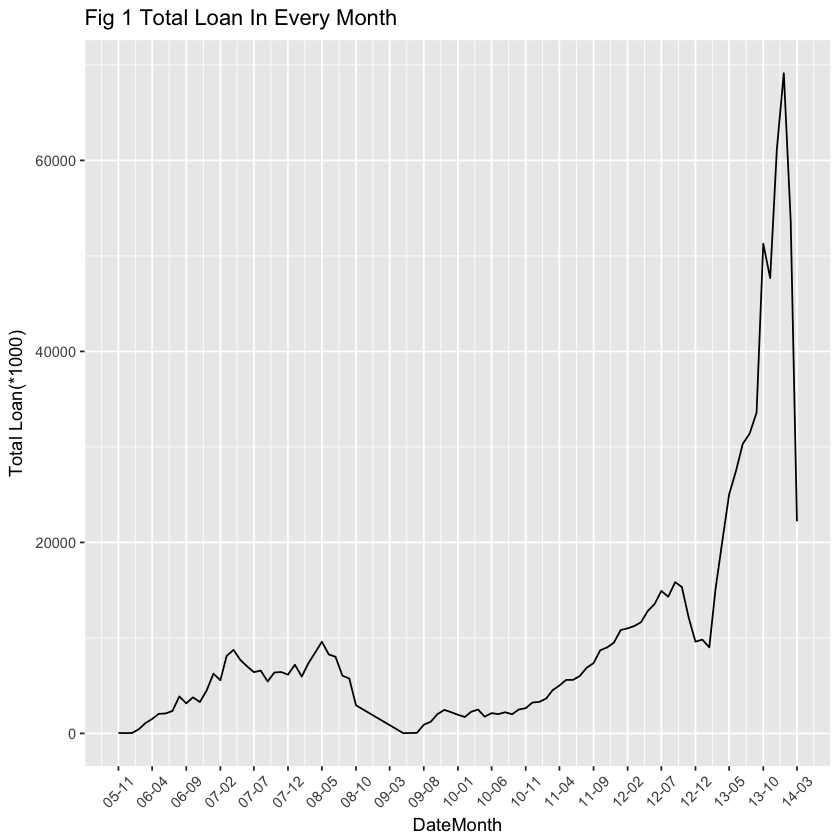

In [12]:
# plot the total loan in every month
ggplot() +
    geom_line(aes(x=DateMonth, y=LoanTotal/1000), data=Loanamount) +
    scale_x_date(date_breaks="5 months", date_labels="%y-%m") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 1 Total Loan In Every Month") +
    ylab("Total Loan(*1000)")

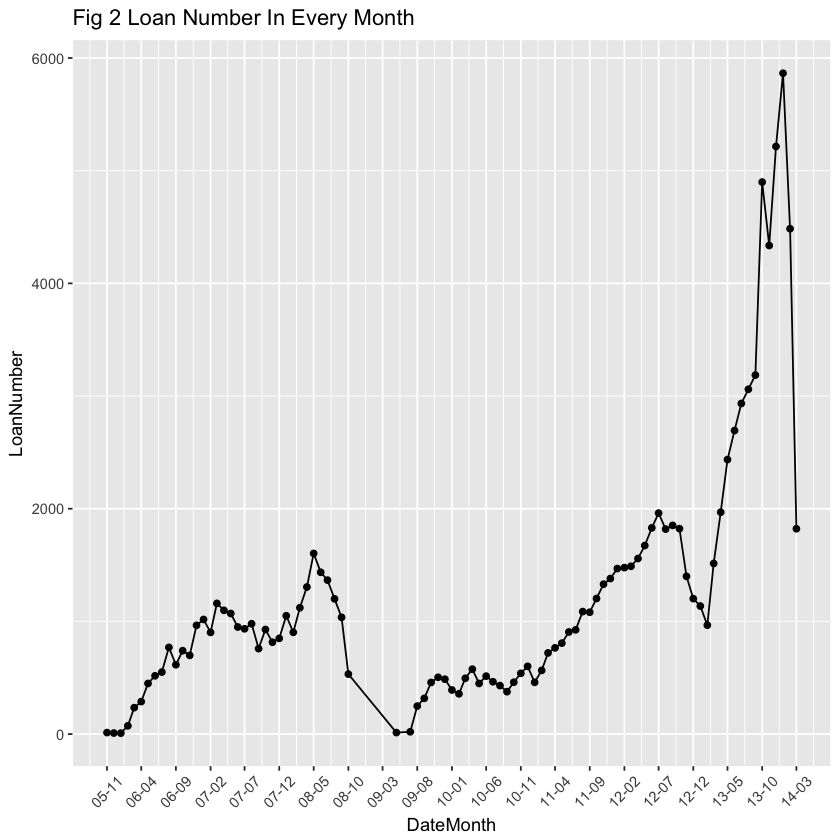

In [13]:
# plot loan number in every month
ggplot(aes(x=DateMonth, y=LoanNumber), data=Loanamount) +
    geom_point() +
    geom_path() +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 2 Loan Number In Every Month") +
    scale_x_date(date_breaks="5 months", date_labels="%y-%m")

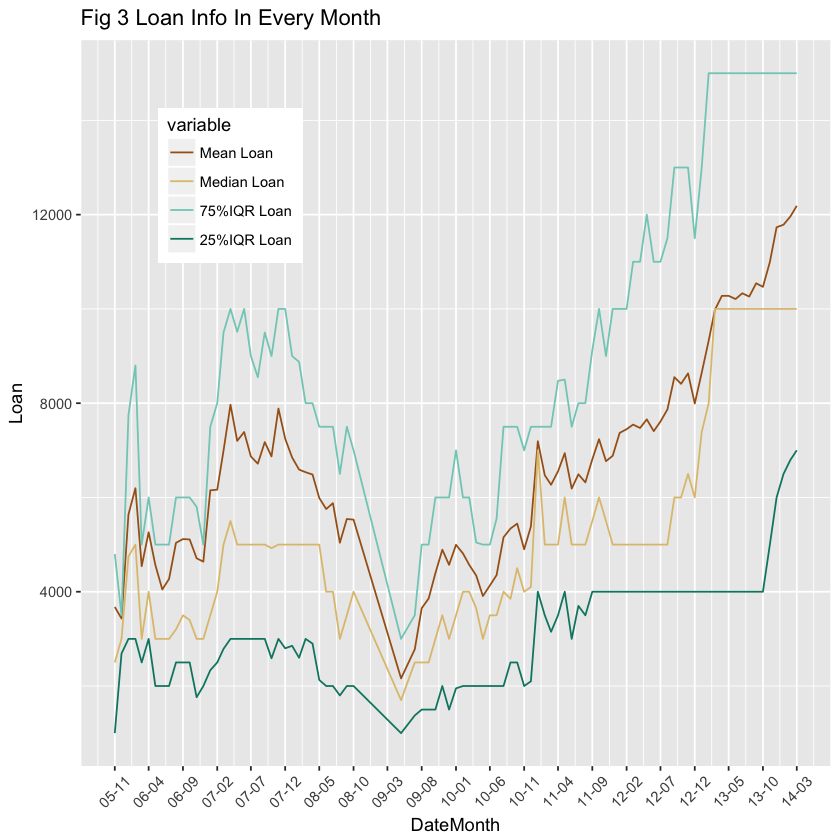

In [14]:
# plot the another stat infomation about loan in every month
Loaninfo <- melt(subset(Loanamount, select=c("DateMonth", "LoanMean", "LoanMedian", "Loan75", "Loan25")),
                 id="DateMonth", measured=c("LoanMean", "LoanMedian", "Loan75", "Loan25"))
Loaninfo$variable <- factor(Loaninfo$variable,
                            levels=c("LoanMean", "LoanMedian", "Loan75", "Loan25"),
                            labels=c("Mean Loan", "Median Loan", "75%IQR Loan", "25%IQR Loan"))

ggplot(aes(x=DateMonth, y=value), data= Loaninfo) +
    geom_line(aes(color=variable)) +
    theme(legend.position=c(0.2,.8)) +
    scale_x_date(date_breaks="5 months", date_labels="%y-%m") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) +
    ggtitle("Fig 3 Loan Info In Every Month") +
    ylab("Loan") +
    scale_color_brewer(type="div")

### 单变量分析
1.Prosper平台贷款状况

以上分析了平台上2005年11月至2014年3月份期间的贷款额，从Fig 1每月贷款额的变化和Fig 2每月交易数量：1)整体趋势上，每月的贷款额在增加。到2013年10月至2014年3月出现了贷款总额快速降低的趋势(降低了近5亿)；2)在2008年10月至2009年8月期间，线段平滑下降。经证实该平台发生了暂停交易，对平台交易可能存在影响；3)2009年8月至2013年10月是Prosper平台高速发展对阶段。从Fig 3每月贷款对其他其他统计信息来看，平台的贷款额表现还是比较优异——平均贷款额的趋势也是在2009年3月之后开始快速提高，另外在小额贷款一直发展缓慢，但是在6000以上的贷款额度发展比较快速；在2013年10月之后小额贷款快速发展。

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5 rows containing non-finite values (stat_bin).”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 8554 rows containing non-finite values (stat_bin).”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 1 rows containing missing values (geom_bar).”

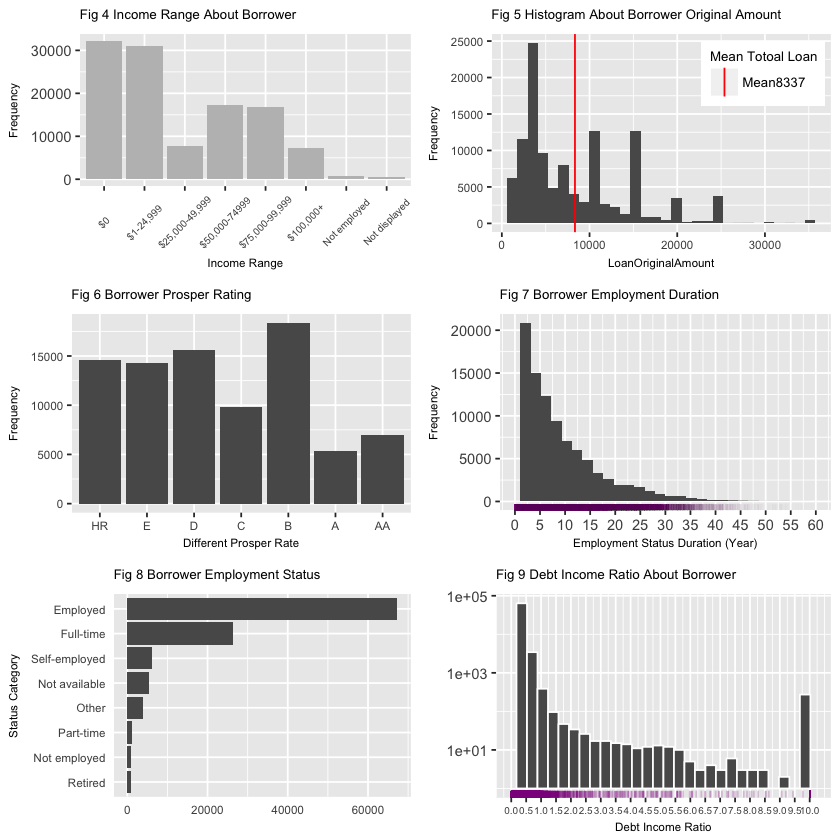

In [84]:
p1 <- ggplot(aes(IncomeRange), data=rawprosper) +
    geom_bar(fill="grey") +
    labs(x="Income Range",y="Frequency", title="Fig 4 Income Range About Borrower") +
    theme(axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5, size=6),
          plot.title=element_text(size=8), axis.title = element_text(size=7))
p2 <- ggplot(aes(LoanOriginalAmount), data=rawprosper) +
    geom_histogram() +
    geom_vline(aes(xintercept=mean(rawprosper$LoanOriginalAmount),colour="Mean8337")) + # adding legend
    scale_colour_manual(name="Mean Totoal Loan", values=c(Mean8337="red")) +
    ggtitle("Fig 5 Histogram About Borrower Original Amount") +
    ylab("Frequency") +
    theme(plot.title=element_text(size=8),legend.position=c(.8,.8),
          legend.title=element_text(size=8), legend.text=element_text(size=8),
          axis.title = element_text(size=7), axis.text=element_text(size=7))

p3 <- ggplot(aes(ProsperRatingAlpha), data=subset(rawprosper, ProsperRatingAlpha != "NA")) +
    geom_bar() +
    ggtitle("Fig 6 Borrower Prosper Rating") +
    labs(y="Frequency", x="Different Prosper Rate") +
    theme(plot.title=element_text(size=8), axis.title=element_text(size=7),
          axis.text=element_text(size=7))

p4 <- ggplot(aes(x=EmploymentStatusDuration/12), data=subset(rawprosper, !is.na(EmploymentStatusDuration))) +
    geom_histogram()+
    geom_rug(sides="b", na.rm=TRUE, alpha=0.01, color="#8B008B") +
    labs(x="Employment Status Duration (Year)", y="Frequency", title="Fig 7 Borrower Employment Duration") +
    scale_x_continuous(limits=c(0, 60), breaks=seq(0, 60, 5)) +
    theme(plot.title=element_text(size=8), axis.title = element_text(size=7))

p5 <- ggplot(aes(reorder(EmploymentStatus, rep(1, length(EmploymentStatus)), sum)),
             data=subset(rawprosper, EmploymentStatus != "NA")) +
    geom_bar() +
    theme(axis.ticks=element_blank()) +
    coord_flip() +
    labs(x="Status Category", y="", title="Fig 8 Borrower Employment Status") +
    theme(plot.title=element_text(size=8), axis.title = element_text(size=7),
         axis.text=element_text(size=7)) # fix the axis text font size

p6 <- ggplot(aes(DebtToIncomeRatio), data=subset(rawprosper, !is.nan(DebtToIncomeRatio))) +
    geom_histogram(color="white") +
    geom_rug(alpha=0.2,color="#8B008B") +
    scale_y_log10() +
    labs(x="Debt Income Ratio", y="", title="Fig 9 Debt Income Ratio About Borrower") +
    scale_x_continuous(limits=c(0, 10.2), breaks=seq(0, 10.2, .5)) +
#     theme(axis.text.y = element_blank()) +
    theme(plot.title=element_text(size=8), axis.title = element_text(size=7), axis.text.x=element_text(size=6))

# plot the all information about borrower
grid.arrange(p1, p2, p3, p4, p5, p6, ncol=2)

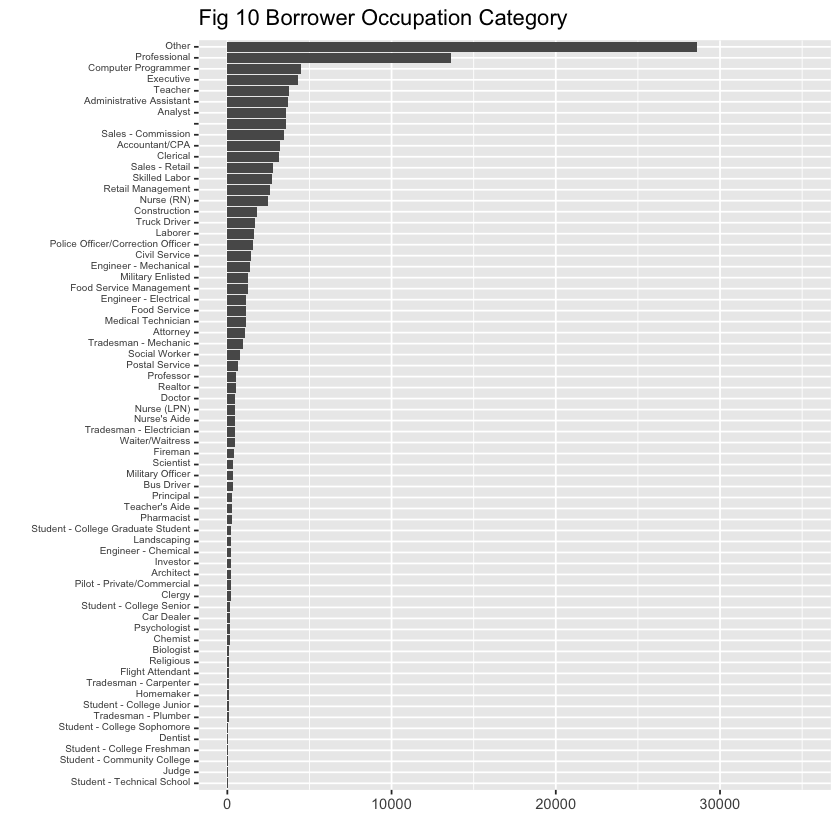

In [83]:
# borrower occupation category
ggplot(aes(reorder(Occupation, rep(1, length(Occupation)), sum)), data=subset(rawprosper, !is.na(Occupation))) +
    geom_bar() +
    coord_flip() +
    ggtitle("Fig 10 Borrower Occupation Category") +
    xlab("") +
    ylab("") +
    scale_y_continuous(limits=c(0, 35000)) +
    theme(axis.text.y = element_text(size=6, vjust=.2))

2.借款人发生贷款时的信息侧写

从借款人的收入情况，开始借款的借款额度，Prosper的信用评级、借款人的工作时间，借款人借款时的工作状态、收入债务比以及职务分类等方面进行了分析，可以发现以下信息：

* 借款人收入情况 从Fig 4 收入范围分布和Fig 9 收入债务比中分析，显示在借款时的收入主要是收入在24,999以下的，另一方面中等收入(收入在50,000至99,999范围内)的借款也相对较高。推测在中等收入借款较高，可能和消费观念有关

* 借款额度方面 可以看出大部分的借款人借款额度都在15000以内，而且平均借款额度在8337左右。另外有借款额度过高的，超过了30000。推测大多人的借款额度没有超过他们的收入，关于这点需要从Fig 9收入债务比来分析，从图中可以看出主要的债务占收入的比重在0.5左右，有少量的借款人的债务占比还是过高达到了10以上，。对借款额度作为投资分析参数，还需要深入分析

* Prosper信用评级方面 借款人的信用评级主要集中HR、E、D、C以及B之间，而在优质等级(A和AA)中发生借款的人数相对较少。可能是Prosper平台的信用评级较严格，这样可以提供一个良好的参数以方便投资人的投资选择。针对这个参数的参考，需要继续分析

* 借款人工作情况 从Fig 7借款人工作实线和Fig 8借款人借款状态来看，主要借款人是有工作的——全职工作人员和被雇佣的人员借款次数角度。同时在工作时限上，可以看出工作了0——10年的借款人比较集中，因为这个时期恰好是身份转换等身份条件变化的时期。

* 借款人职务 从Fig 10展示的借款人的职务来看，职务信息不是很全面。因为在选择职务为Other的借款人明显偏多，不具有显著对分析作用。针对这一点，涉及到个人隐私等方面的问题。但是从其他数据职务数据来看受教育的借款人员——教授、编程工作人员、行政人员等，发生借款次数较多

In [18]:
sort(names(rawprosper))

[1] "AmountDelinquent"                    "AvailableBankcardCredit"            
 [3] "BankcardUtilization"                 "BorrowerAPR"                        
 [5] "BorrowerRate"                        "BorrowerState"                      
 [7] "ClosedDate"                          "CreditGrade"                        
 [9] "CreditScoreRangeLower"               "CreditScoreRangeUpper"              
[11] "CurrentCreditLines"                  "CurrentDelinquencies"               
[13] "CurrentlyInGroup"                    "DateCreditPulled"                   
[15] "DebtToIncomeRatio"                   "DelinquenciesLast7Years"            
[17] "EmploymentStatus"                    "EmploymentStatusDuration"           
[19] "EstimatedEffectiveYield"             "EstimatedLoss"                      
[21] "EstimatedReturn"                     "FirstRecordedCreditLine"            
[23] "GroupKey"                            "IncomeRange"                        
[25] "IncomeVerifiable"                    "InquiriesLast6Months"               
[27] "InvestmentFromFriendsAmount"         "InvestmentFromFriendsCount"         
[29] "Investors"                           "IsBorrowerHomeowner"                
[31] "LP_CollectionFees"                   "LP_CustomerPayments"                
[33] "LP_CustomerPrincipalPayments"        "LP_GrossPrincipalLoss"              
[35] "LP_InterestandFees"                  "LP_NetPrincipalLoss"                
[37] "LP_NonPrincipalRecoverypayments"     "LP_ServiceFees"                     
[39] "LenderYield"                         "ListingCategoryNumeric"             
[41] "ListingCreationDate"                 "ListingKey"                         
[43] "ListingNumber"                       "LoanCurrentDaysDelinquent"          
[45] "LoanFirstDefaultedCycleNumber"       "LoanKey"                            
[47] "LoanMonthsSinceOrigination"          "LoanNumber"                         
[49] "LoanOriginalAmount"                  "LoanOriginationDate"                
[51] "LoanOriginationQuarter"              "LoanStatus"                         
[53] "MemberKey"                           "MonthlyLoanPayment"                 
[55] "Occupation"                          "OnTimeProsperPayments"              
[57] "OpenCreditLines"                     "OpenRevolvingAccounts"              
[59] "OpenRevolvingMonthlyPayment"         "PercentFunded"                      
[61] "ProsperPaymentsLessThanOneMonthLate" "ProsperPaymentsOneMonthPlusLate"    
[63] "ProsperPrincipalBorrowed"            "ProsperPrincipalOutstanding"        
[65] "ProsperRatingAlpha"                  "ProsperRatingNumeric"               
[67] "ProsperScore"                        "PublicRecordsLast10Years"           
[69] "PublicRecordsLast12Months"           "Recommendations"                    
[71] "RevolvingCreditBalance"              "ScorexChangeAtTimeOfListing"        
[73] "StatedMonthlyIncome"                 "Term"                               
[75] "TotalCreditLinespast7years"          "TotalInquiries"                     
[77] "TotalProsperLoans"                   "TotalProsperPaymentsBilled"         
[79] "TotalTrades"                         "TradesNeverDelinquentPercentage"    
[81] "TradesOpenedLast6Months"

## 参考
1. [马赛克图](https://itunes.apple.com/cn/album/waiting-for-the-end-the-glitch-mob-remix/397873565?i=397873589)
2. [条形图梯度排序](https://ask.hellobi.com/blog/Data_AnalysisR/8808)